Creating customer features...
Created feature matrix with shape: (199, 14)

Evaluating different numbers of clusters...


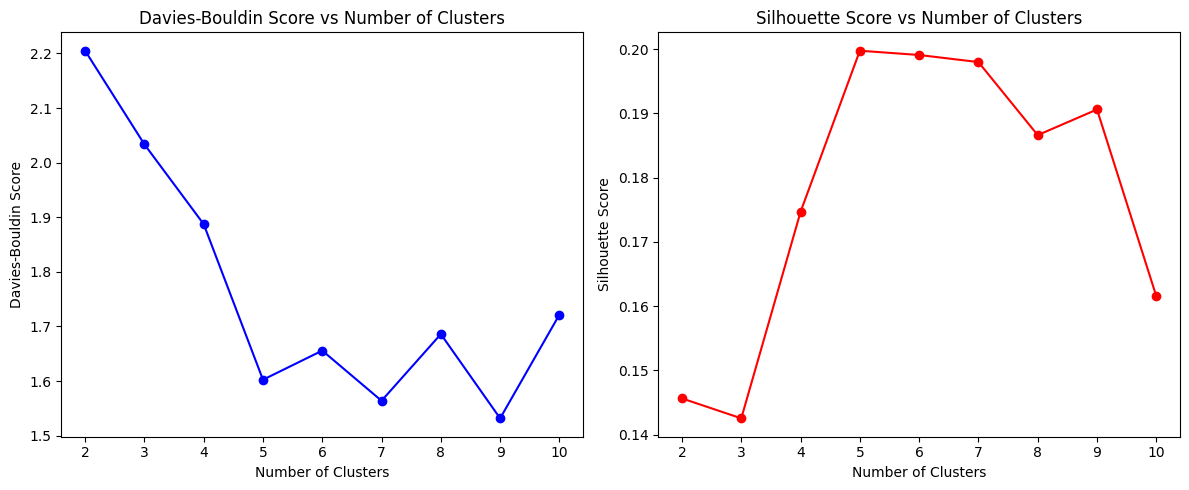


Cluster evaluation metrics:
   n_clusters  db_score  silhouette
0           2  2.205044    0.145623
1           3  2.033549    0.142520
2           4  1.887337    0.174676
3           5  1.602342    0.199768
4           6  1.655731    0.199102
5           7  1.563836    0.198000
6           8  1.685926    0.186622
7           9  1.531650    0.190617
8          10  1.721598    0.161546

Performing clustering with 4 clusters...


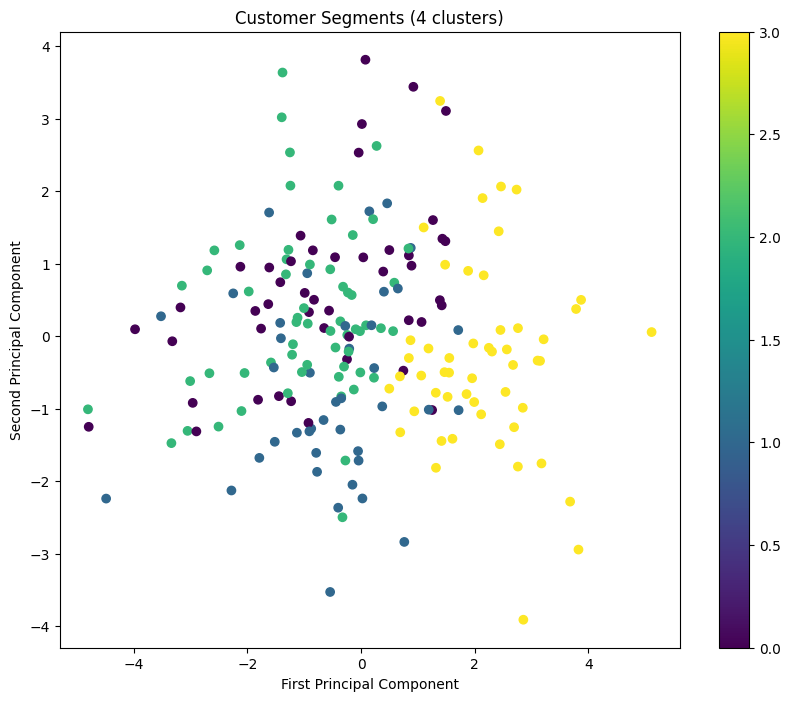


Clustering Metrics for 4 clusters:
Davies-Bouldin Score: 1.887
Silhouette Score: 0.175

Analyzing cluster characteristics...

Cluster Profiles:
   Cluster  Size  Avg Total Value  Avg Quantity  Avg Order Value
0        0    46      2995.686522     10.847826       675.286122
1        1    41      2890.348780     11.292683       630.507093
2        2    60      2295.545500      8.816667       618.997917
3        3    52      5691.479808     20.115385       822.589015

Results saved to FirstName_LastName_Clustering.csv


In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# First, let's create our preprocessing function
def create_customer_features():
    """
    Creates customer features from the raw data files
    """
    # Read the data
    customers = pd.read_csv('Customers.csv')
    products = pd.read_csv('Products.csv')
    transactions = pd.read_csv('Transactions.csv')

    # Basic customer metrics
    customer_metrics = transactions.groupby('CustomerID').agg({
        'TotalValue': ['sum', 'mean'],
        'Quantity': ['sum', 'mean'],
        'Price': 'mean'
    }).reset_index()

    # Flatten column names
    customer_metrics.columns = ['CustomerID', 'total_value', 'avg_value',
                              'total_quantity', 'avg_quantity', 'avg_price']

    # Add customer region (one-hot encoded)
    region_dummies = pd.get_dummies(customers['Region'], prefix='region')
    region_dummies['CustomerID'] = customers['CustomerID']

    # Get product category preferences
    transactions_with_products = transactions.merge(products[['ProductID', 'Category']],
                                                 on='ProductID')

    category_preferences = pd.crosstab(transactions_with_products['CustomerID'],
                                     transactions_with_products['Category'])
    category_preferences = category_preferences.reset_index()

    # Merge all features
    final_features = customer_metrics.merge(region_dummies, on='CustomerID')
    final_features = final_features.merge(category_preferences, on='CustomerID')

    return final_features

def evaluate_clusters(features, max_clusters=10):
    """
    Evaluates different numbers of clusters using DB Index and Silhouette Score
    """
    # Scale the features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features.drop('CustomerID', axis=1))

    # Store metrics
    metrics = []

    # Try different numbers of clusters
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels = kmeans.fit_predict(features_scaled)

        db_score = davies_bouldin_score(features_scaled, labels)
        silhouette = silhouette_score(features_scaled, labels)

        metrics.append({
            'n_clusters': n_clusters,
            'db_score': db_score,
            'silhouette': silhouette
        })

    metrics_df = pd.DataFrame(metrics)

    # Plot metrics
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(metrics_df['n_clusters'], metrics_df['db_score'], 'bo-')
    plt.title('Davies-Bouldin Score vs Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Davies-Bouldin Score')

    plt.subplot(1, 2, 2)
    plt.plot(metrics_df['n_clusters'], metrics_df['silhouette'], 'ro-')
    plt.title('Silhouette Score vs Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')

    plt.tight_layout()
    plt.show()

    return metrics_df

def perform_clustering(features, n_clusters):
    """
    Performs the actual clustering and returns labels and visualization
    """
    # Prepare features
    features_for_clustering = features.drop('CustomerID', axis=1)

    # Scale features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features_for_clustering)

    # Perform clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(features_scaled)

    # Reduce dimensionality for visualization
    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(features_scaled)

    # Create visualization
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1],
                         c=labels, cmap='viridis')
    plt.colorbar(scatter)
    plt.title(f'Customer Segments ({n_clusters} clusters)')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()

    # Return cluster labels and metrics
    db_score = davies_bouldin_score(features_scaled, labels)
    silhouette = silhouette_score(features_scaled, labels)

    print(f"\nClustering Metrics for {n_clusters} clusters:")
    print(f"Davies-Bouldin Score: {db_score:.3f}")
    print(f"Silhouette Score: {silhouette:.3f}")

    # Add labels to features
    results = features.copy()
    results['Cluster'] = labels

    return results

def analyze_clusters(clustered_data):
    """
    Analyzes the characteristics of each cluster
    """
    cluster_profiles = []

    for cluster in sorted(clustered_data['Cluster'].unique()):
        cluster_data = clustered_data[clustered_data['Cluster'] == cluster]

        # Calculate key metrics
        profile = {
            'Cluster': cluster,
            'Size': len(cluster_data),
            'Avg Total Value': cluster_data['total_value'].mean(),
            'Avg Quantity': cluster_data['total_quantity'].mean(),
            'Avg Order Value': cluster_data['avg_value'].mean()
        }

        cluster_profiles.append(profile)

    return pd.DataFrame(cluster_profiles)

# Main execution
if __name__ == "__main__":
    # Create feature matrix
    print("Creating customer features...")
    features = create_customer_features()
    print(f"Created feature matrix with shape: {features.shape}")

    # Evaluate different numbers of clusters
    print("\nEvaluating different numbers of clusters...")
    metrics = evaluate_clusters(features)
    print("\nCluster evaluation metrics:")
    print(metrics)

    # Perform clustering with optimal number of clusters
    # You can adjust this number based on the evaluation metrics
    optimal_clusters = 4
    print(f"\nPerforming clustering with {optimal_clusters} clusters...")
    clustered_data = perform_clustering(features, optimal_clusters)

    # Analyze clusters
    print("\nAnalyzing cluster characteristics...")
    cluster_profiles = analyze_clusters(clustered_data)
    print("\nCluster Profiles:")
    print(cluster_profiles)

    # Save cluster profiles to file
    cluster_profiles.to_csv('FirstName_LastName_Clustering.csv', index=False)
    print("\nResults saved to FirstName_LastName_Clustering.csv")